In [1]:
# Running RandomForest regressions to discover a lifters best lift
# across the 3 lifts.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import load_digits

In [2]:
# Sampling 20,000 data entries
n = 767672 
s = 20000
skip = sorted(random.sample(range(1,n+1),n-s))
data = pd.read_csv('zeroopenpowerlifting.csv', skiprows=skip)
data

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date
0,Kate Drinkwater,F,SBD,Wraps,28.0,24-34,F-OR,51.20,52,100.0,...,282.5,2,356.40,356.40,316.12,536.69,NaN,NaN,GPC-AUS,2018-10-27
1,Dallas Sciascia,M,SBD,Wraps,38.0,35-39,M-OR,137.80,140,280.0,...,810.0,4,453.72,453.72,430.16,619.50,NaN,Australia,GPC-AUS,2018-10-27
2,Damir Matecic,M,SBD,Wraps,35.0,35-39,M-OR,137.80,140,280.0,...,825.0,3,462.13,462.13,438.13,632.54,NaN,NaN,GPC-AUS,2018-10-27
3,Dean Panopoulos,M,SBD,Wraps,26.0,24-34,M-OR,81.70,82.5,202.5,...,565.0,4,380.73,380.73,367.63,562.92,NaN,Australia,GPC-AUS,2018-10-27
4,Gilbert Tan,M,SBD,Wraps,27.0,24-34,M-OR,99.60,100,200.0,...,612.5,7,373.36,373.36,358.87,541.77,NaN,NaN,GPC-AUS,2018-10-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Chris Pereira,M,SBD,Wraps,22.0,20-23,jr,89.81,90,0.0,...,695.0,1,444.16,448.60,425.72,668.52,Yes,USA,NASA,2019-07-20
19996,Cyndi Crossland,F,B,Raw,56.5,55-59,wbpm2,74.84,75,0.0,...,90.0,1,85.67,106.75,75.37,671.30,Yes,USA,NASA,2019-09-21
19997,Alexander Ersing,M,BD,Raw,32.0,24-34,sm1,74.89,75,0.0,...,380.0,1,271.05,271.05,261.92,NaN,Yes,USA,NASA,2019-06-22
19998,Shane Robertson,M,SBD,Wraps,40.5,40-44,mp,101.70,110,0.0,...,685.0,1,414.14,414.14,395.47,608.07,Yes,USA,NASA,2019-08-17


In [3]:
# Dropping columns not needed for this test
data = data.drop(columns=['Name', 'AgeClass', 'Division',
                          'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg',
                          'Place', 'Tested', 'Country', 'Federation',
                          'Date', 'IPFPoints', 'TotalKg', 'Squat1Kg',
                          'Squat2Kg', 'Squat3Kg','Bench1Kg', 'Bench2Kg',
                          'Bench3Kg', 'Deadlift1Kg', 'Deadlift2Kg',
                          'Deadlift3Kg', 'McCulloch', 'Glossbrenner',
                          'WeightClassKg'])

data.columns
data.isnull().sum()

Sex                   0
Event                 0
Equipment             0
Age                   0
BodyweightKg          0
Best3SquatKg          0
Best3BenchKg          0
Best3DeadliftKg       0
Wilks              1198
dtype: int64

In [4]:
# General dropna just  to clear those without a WILKS
data = data.dropna()

In [5]:
# Dropping athletes who did not compete in complete SBD competitions
indexNames = data[data['Event'] == 'S'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'B'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'D'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SD'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SB'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'BD'].index
data.drop(indexNames, inplace=True)

In [6]:
# Remove the last couple of columns
data = data.drop(columns = ['Event'])

In [7]:
data

,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,F,Wraps,28.0,51.20,110.0,47.5,125.0,356.40
1,M,Wraps,38.0,137.80,315.0,187.5,307.5,453.72
2,M,Wraps,35.0,137.80,300.0,210.0,315.0,462.13
3,M,Wraps,26.0,81.70,215.0,120.0,230.0,380.73
4,M,Wraps,27.0,99.60,215.0,155.0,242.5,373.36
...,...,...,...,...,...,...,...,...
19992,M,Wraps,56.0,123.29,275.0,182.5,285.0,424.32
19993,M,Wraps,55.5,73.30,147.5,110.0,170.0,309.60
19994,F,Wraps,28.5,66.63,107.5,62.5,132.5,311.64
19995,M,Wraps,22.0,89.81,245.0,175.0,275.0,444.16


In [8]:
# Convert string data to numeric
sex = {'M': 1, 'F': 0, 'Mx': 3}
equipment = {'Raw': 0, 'Wraps': 1, 'Multi-ply': 2, 'Single-ply': 3, 'Straps': 4}

data.Sex = [sex[item] for item in data.Sex]
data.Equipment = [equipment[item] for item in data.Equipment]

data

,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,0,1,28.0,51.20,110.0,47.5,125.0,356.40
1,1,1,38.0,137.80,315.0,187.5,307.5,453.72
2,1,1,35.0,137.80,300.0,210.0,315.0,462.13
3,1,1,26.0,81.70,215.0,120.0,230.0,380.73
4,1,1,27.0,99.60,215.0,155.0,242.5,373.36
...,...,...,...,...,...,...,...,...
19992,1,1,56.0,123.29,275.0,182.5,285.0,424.32
19993,1,1,55.5,73.30,147.5,110.0,170.0,309.60
19994,0,1,28.5,66.63,107.5,62.5,132.5,311.64
19995,1,1,22.0,89.81,245.0,175.0,275.0,444.16


In [9]:
# Normalise the data, scaling to values between 0-1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data[['Sex', 'Age', 'Equipment', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']] = scaler.fit_transform(data[['Sex', 'Age', 'Equipment', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']])

In [10]:
# So, running 3 different test and training sets.
# First for squats, then bench, finally deadlifts,
# See the model accuracy for predicting someone's lifts.
# Further experiments to see which variables are critical
# to accurate prediction. How accurate can we get with age,
# sex, weight, and equipment?

test_squat = data[[ 'Sex', 'Age', 'BodyweightKg', 'Equipment', 'Wilks']]

target_squat = data[['Best3SquatKg']]

test_bench = data[['Sex', 'Age', 'BodyweightKg', 'Equipment', 'Wilks']]

target_bench = data[['Best3BenchKg']]

test_dead = data[['Sex', 'Age', 'BodyweightKg', 'Equipment', 'Wilks']]

target_dead = data[['Best3DeadliftKg']]

In [11]:
# Preparing sets
S = test_squat
s = target_squat
B = test_bench
b = target_bench
D = test_dead
d = target_dead

In [12]:
# Split sets into training and test sets
from sklearn.model_selection import train_test_split
S_train, S_test, s_train, s_test = train_test_split(S, s, test_size=0.1, random_state=3)
B_train, B_test, b_train, b_test = train_test_split(B, b, test_size=0.1, random_state=3)
D_train, D_test, d_train, d_test = train_test_split(D, d, test_size=0.1, random_state=3)

In [13]:
# Prepare model, then fit the models and check scores!
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, max_depth = 30)

In [14]:
model.fit(S_train, s_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [15]:
S_pred = model.predict(S_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(S_pred , s_test))

R2-score: 0.96


In [16]:
model.fit(B_train, b_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [17]:
B_pred = model.predict(B_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(B_pred , b_test))

R2-score: 0.90


In [18]:
model.fit(D_train, d_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [19]:
D_pred = model.predict(D_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(D_pred , d_test))

R2-score: 0.92


In [20]:
s_pred = pd.DataFrame(model.predict(S_test))
S_bw = pd.DataFrame(S_test['BodyweightKg'])
S_bw = S_bw.reset_index()
s_pred = s_pred.reset_index()
S_bw = S_bw.drop(columns = 'index')
s_pred = s_pred.drop(columns = 'index')
s_t = s_test.reset_index()
s_t = s_t.drop(columns = 'index')

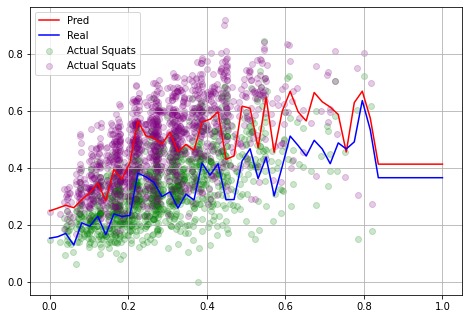

In [32]:
xfit = np.linspace(0, 1)
yfit = RandomForestRegressor().fit(S_bw, s_pred.values.ravel()).predict(xfit[:, None])
zfit = RandomForestRegressor().fit(S_bw, s_test.values.ravel()).predict(xfit[:, None])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.2)
ax.scatter(S_bw, s_pred, color = 'purple', label='Actual Squats', alpha=0.2)
plt.plot(xfit, yfit, '-r', color='red', label='Pred')
plt.plot(xfit, zfit, '-k', color='blue', label='Real')
#plt.errorbar(xfit, yfit, 0.1, fmt='r')
ax.legend()
ax.grid(True)
plt.show()